# reference molecule data


In [ ]:
import json
import os
import pandas as pd


# ##### protein type #####
# protein_type ='unseen_proteins'
# ########################

with open('./post_filter_data/UniprotIDs_duplicated_with_crossdock2020.json','r') as f:
    UniprotId_in_crossdock = json.load(f)


def get_reference_stats(protein_type='all_proteins'):

    merged_df_ref = pd.read_csv('./post_filter_data/chemFilters_result_repeats/merged_denovo_and_reference_results.csv')

    if protein_type == 'all_proteins':
        pass
    elif protein_type == 'unseen_proteins':
        merged_df_ref = merged_df_ref[~merged_df_ref['UniprotID'].isin(UniprotId_in_crossdock.keys())]
    elif protein_type == 'seen_proteins':
        merged_df_ref = merged_df_ref[merged_df_ref['UniprotID'].isin(UniprotId_in_crossdock.keys())]
    print(merged_df_ref['UniprotID'].nunique())
    merged_df_ref  = merged_df_ref [merged_df_ref['Model'] == 'Reference'].reset_index(drop=True)
    reference_pass_all = pd.DataFrame(merged_df_ref.groupby(["Model"])["pass_all"].sum()/(len(merged_df_ref))).reset_index()['pass_all'][0]
    merged_df_ref_scaffold  = merged_df_ref[merged_df_ref['pass_all'] == True].reset_index()
    merged_df_ref_scaffold = merged_df_ref_scaffold.groupby(['Model','UniprotID'])['Scaffold'].unique().reset_index()
    merged_df_ref_scaffold['Scaffold_Num'] = merged_df_ref_scaffold['Scaffold'].apply(lambda x: len([ i for i in x if i != 'None']))
    merged_df_ref_scaffold = pd.DataFrame(merged_df_ref_scaffold.groupby("Model")["Scaffold_Num"].sum()/(len(merged_df_ref))).reset_index()
    merged_df_ref_scaffold['Scaffold_rate'] = merged_df_ref_scaffold['Scaffold_Num']
    reference_pass_all_scaffold = merged_df_ref_scaffold['Scaffold_Num'][0]

    return reference_pass_all,reference_pass_all_scaffold


for protein_type in ["all_proteins", "seen_proteins", "unseen_proteins"]:
    reference_pass_all,reference_pass_all_scaffold = get_reference_stats(protein_type=protein_type)
    print(f"{protein_type}: {reference_pass_all}, {reference_pass_all_scaffold}")

120
all_proteins: 0.6838792326889851, 0.27793242464964485
85
seen_proteins: 0.6696572942867409, 0.2688420768954366
35
unseen_proteins: 0.7111884945448272, 0.295387899435077


# 画图

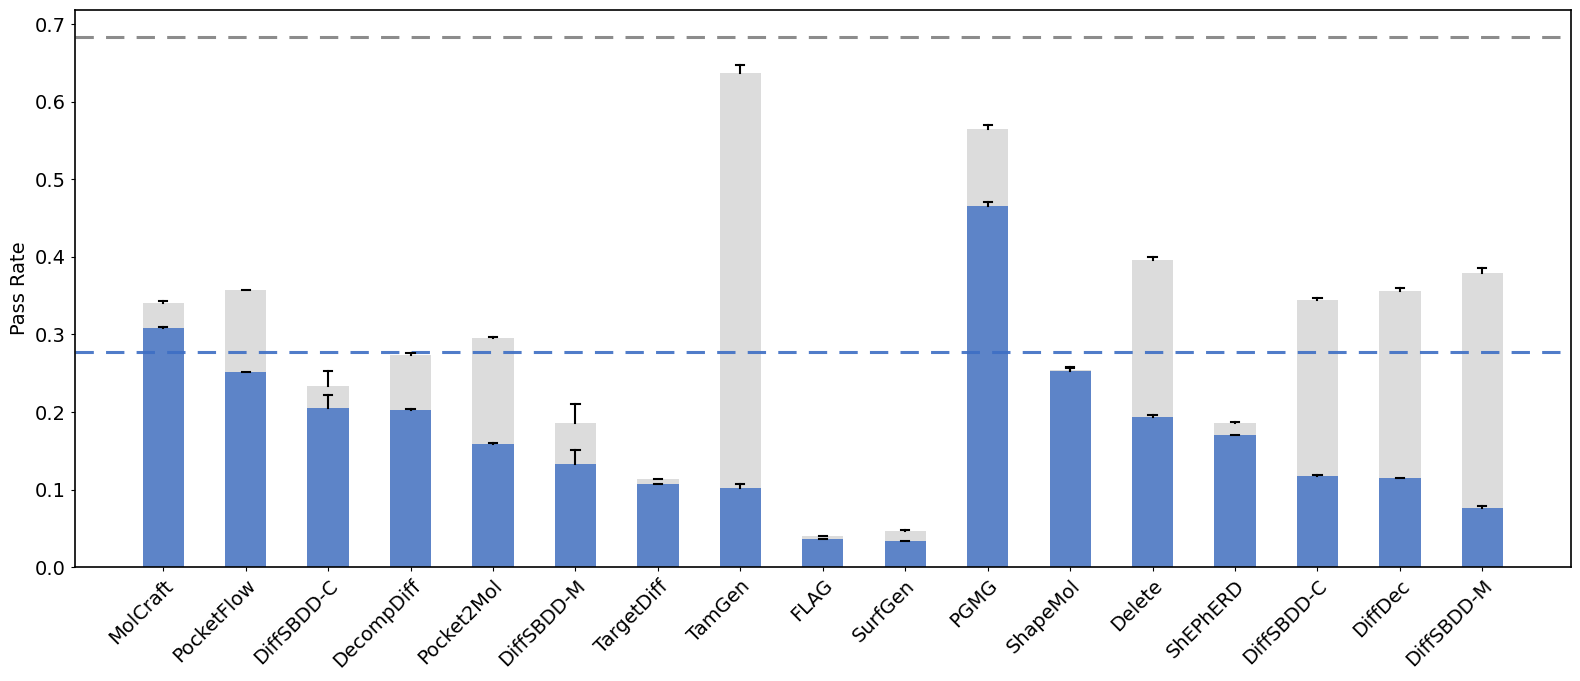

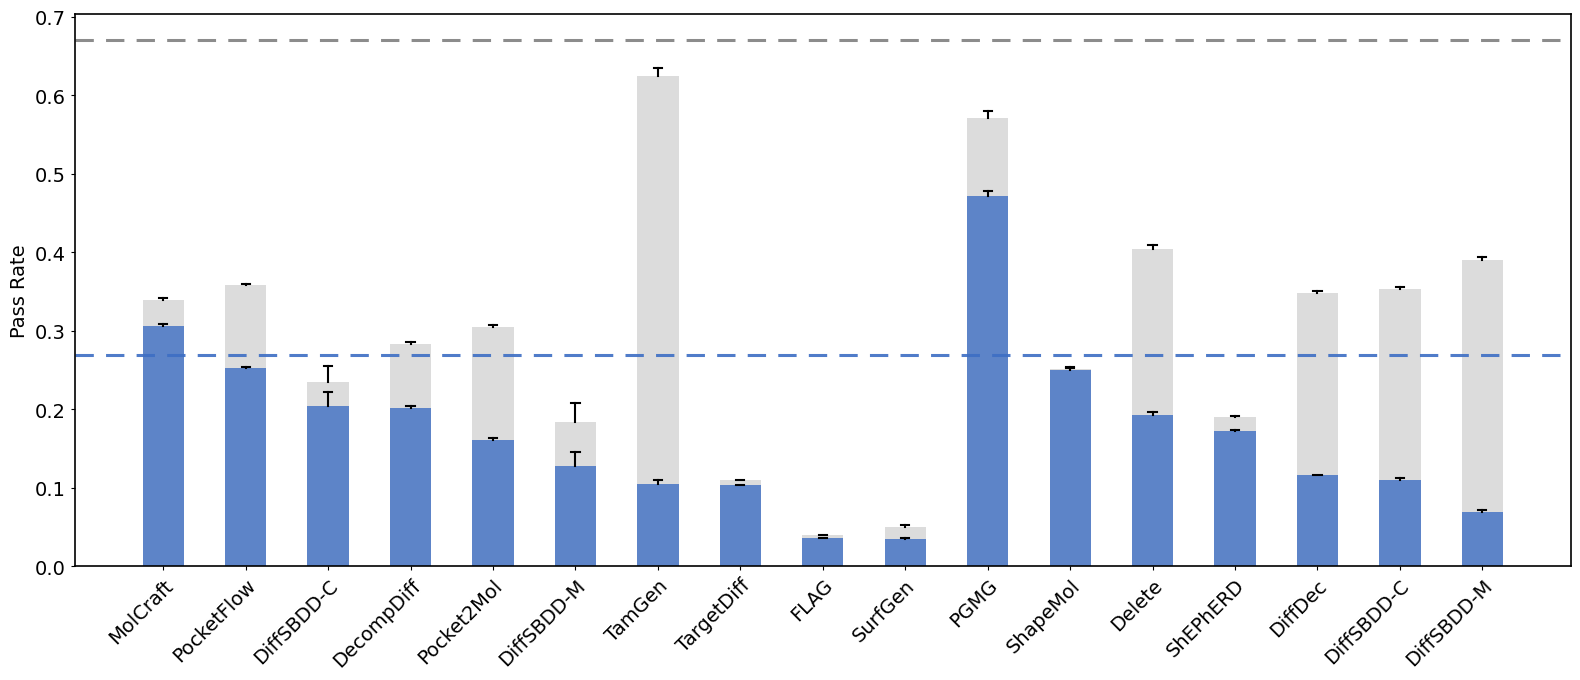

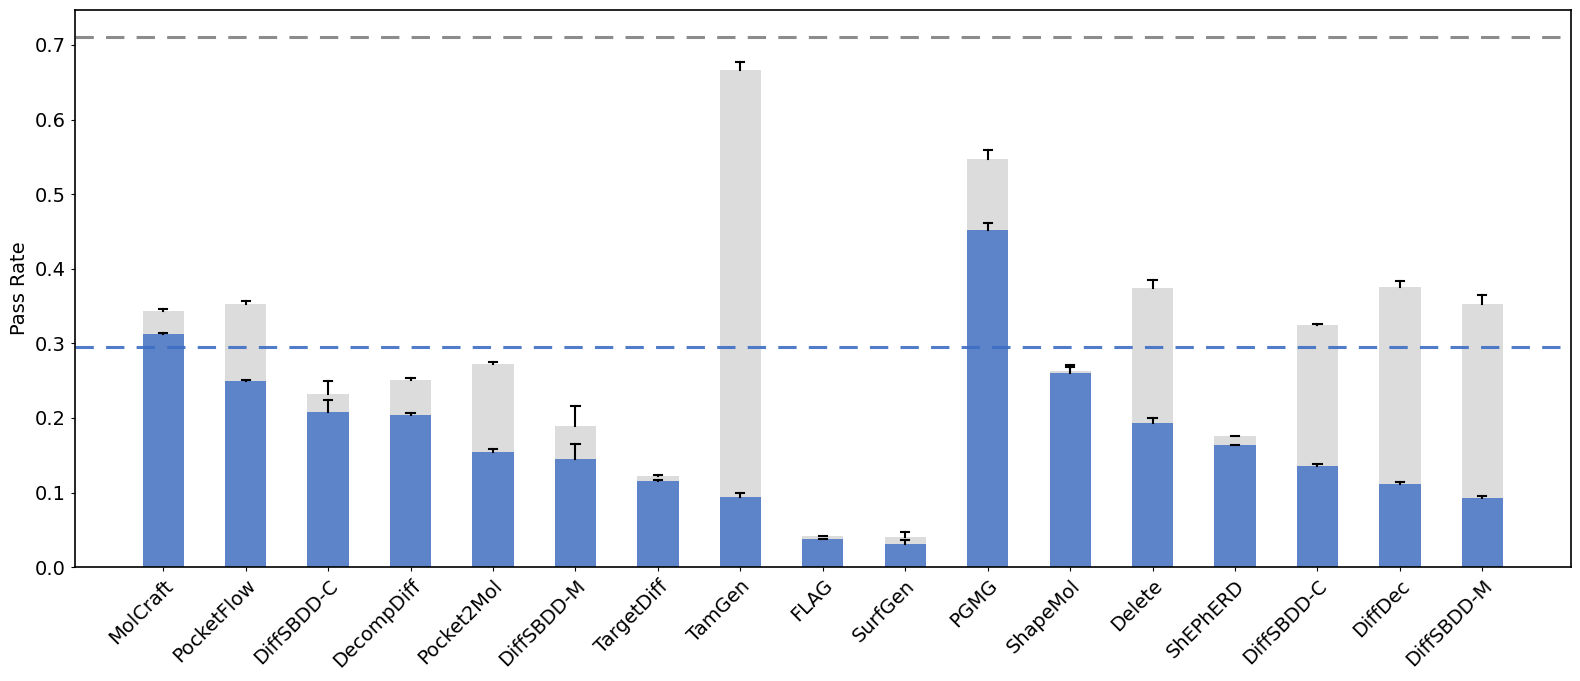

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

protein_type_list = ["all_proteins", "seen_proteins", "unseen_proteins"]

for protein_type in protein_type_list:

    if protein_type == "all_proteins":
        reference_pass_all, reference_pass_all_scaffold = 0.6838792326889851, 0.27793242464964485
    elif protein_type == "seen_proteins":
        reference_pass_all, reference_pass_all_scaffold = 0.6696572942867409, 0.2688420768954366
    elif protein_type == "unseen_proteins":
        reference_pass_all, reference_pass_all_scaffold = 0.7111884945448272, 0.295387899435077
        
    df_denovo = pd.read_csv(f"./post_filter_data/only_chem_filter_result/denovo_{protein_type}_repeats_posefilter_metrics.csv")
    df_hit2lead = pd.read_csv(f"./post_filter_data/only_chem_filter_result/hit2lead_{protein_type}_repeats_posefilter_metrics.csv")

    def upper_err(var_series):
        return [np.zeros_like(var_series), np.sqrt(var_series)]

    
    df_denovo = df_denovo.sort_values(by="pass_chem_and_scaffold_unique_mean", ascending=False)
    df_hit2lead = df_hit2lead.sort_values(by="pass_chem_and_scaffold_unique_mean", ascending=False)

    df_denovo["Type"] = "De novo"
    df_hit2lead["Type"] = "Hit to Lead"
    df_all = pd.concat([df_denovo, df_hit2lead], ignore_index=True)

    fig, ax = plt.subplots(figsize=(16, 7))

    # Create positions for the bars
    x_pos = np.arange(len(df_all["Model"]))
    bar_width = 0.5


    # reference
    ax.axhline(
        reference_pass_all,
        color="gray",
        linestyle=(0, (6, 4)),
        linewidth=2.2,
        label="Pass All Chem Filters (Reference)",
        alpha=0.9
    )

    # “Unique Scaffolds” reference
    ax.axhline(
        reference_pass_all_scaffold,
        color="#3D6EC4",
        linestyle=(0, (6, 4)),
        linewidth=2.2,
        label="Pass All Chem Filters & Unique Scaffolds (Reference)",
        alpha=0.9
    )

    # Create bars for pass_all (empty/hollow bars)
    bars1 = ax.bar(x_pos, df_all["pass_chem_mean"], 
                bar_width,
                label="Pass All Chem Filters", 
                color="#D4D4D4", 
                linewidth=1.5,
                alpha=0.8,
                capsize=3)

    bars2 = ax.bar(x_pos, df_all["pass_chem_and_scaffold_unique_mean"], 
                bar_width,
                label="Pass All Chem Filters & Unique Scaffolds", 
                color="#3D6EC4", 
                alpha=0.8,
                )

    # ============================
    # error bar
    # ============================
    for i, (bar, mean, var) in enumerate(zip(bars1, df_all["pass_chem_mean"], df_all["pass_chem_var"])):
        err = np.sqrt(var)
        ax.plot([bar.get_x() + bar.get_width() / 2, bar.get_x() + bar.get_width() / 2],
                [mean, mean + err],
                color='black', linewidth=1.5)
        ax.plot([bar.get_x() + bar.get_width() / 2 - 0.05, bar.get_x() + bar.get_width() / 2 + 0.05],
                [mean + err, mean + err],
                color='black', linewidth=1.5)

    for i, (bar, mean, var) in enumerate(zip(bars2, df_all["pass_chem_and_scaffold_unique_mean"], df_all["pass_chem_and_scaffold_unique_var"])):
        err = np.sqrt(var)
        ax.plot([bar.get_x() + bar.get_width() / 2, bar.get_x() + bar.get_width() / 2],
                [mean, mean + err],
                color='black', linewidth=1.5)
        ax.plot([bar.get_x() + bar.get_width() / 2 - 0.05, bar.get_x() + bar.get_width() / 2 + 0.05],
                [mean + err, mean + err],
                color='black', linewidth=1.5)
        
        
    ax.set_ylabel("Pass Rate", fontsize=14)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(df_all["Model"], rotation=45, ha='right', rotation_mode='anchor', fontsize=14,)
    ax.tick_params(axis='y', labelsize=14)

    plt.tight_layout()
    plt.savefig(os.path.join('./final_plot/output', f'09-post_filter_merge_{protein_type}.svg'), format='svg')

    plt.show()
    plt.close()